This notebook looks at the possibility to detect two bmack holes event when they are in the same window frame and when they end-up overlapping. Here, it is done for the GW170814  event and an injected event close-by. However, in this situation, we see that there are problems due to the amplitude of the injection of the signal, as well as the  glitch present. We look at the influence of these on the overlapping signal. This will motivate the choice of another event to do the overlapping signals, as well as the masses of the injected signal. 

Here, we do more a preliminary search of this behaviour. So, we focus only on one detector.

In [10]:
#test for amplitude signalµ
import numpy

merger = Merger('GW170814')
stra = merger.strain('L1')

ind = stra.numpy().argmax()
amp = stra[ind]

print(amp)

3.398619154333267e-19


In [11]:
from pycbc.waveform import get_td_waveform

hpInj, _ = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 18.,
                        mass2 = 30., delta_t = strain.delta_t, 
                        distance = 580,f_lower = 15.)

idx = hpInj.numpy().argmax()
ampInj = hpInj[idx]

print(ampInj)

8.451108821170589e-22


In [12]:
ratio = float(ampInj)/float(amp)
print(ratio)

0.0024866301393


In [1]:
# beautiful plots
%matplotlib inline 

#first we need to set bigger characters for the titles, labels and thicks.
import matplotlib
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

In [2]:
#library import 
from pycbc.catalog import Merger
from pycbc.psd import interpolate, inverse_spectrum_truncation

In [7]:
m = Merger('GW170814')
strain = m.strain('L1')
strain = strain.highpass_fir(20,512)
strain = strain.whiten(4,4)
strain = strain.crop(2,2)

psd = strain.psd(2)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 2*strain.sample_rate, 
                                 low_frequency_cutoff = 15.0)

/home/justin/.local/lib/python2.7/site-packages/matplotlib/axes/_base.py:3477: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


Text(0,0.5,'Normalized amplitude')

/home/justin/.local/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


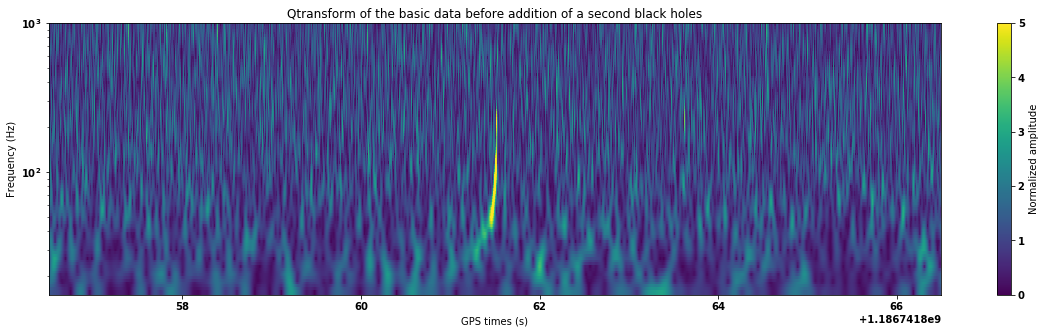

In [4]:
#qtransform of the data

zoom = strain.time_slice(m.time-5, m.time+5)
t, f, p = zoom.qtransform(0.001, logfsteps = 100, qrange = (8,8),
                         frange=(15,1000))
plt.figure(figsize = [20,5])
plt.title("Qtransform of the basic data before addition of a second black holes")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS times (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0,1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

In [5]:
#make template that can add
from pycbc.waveform import get_td_waveform

hp, hc = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 18.,
                        mass2 = 30., delta_t = strain.delta_t, 
                         f_lower = 15.)
hp.resize(len(strain))
hp = hp.cyclic_time_shift(12)
hp.start_time = strain.start_time

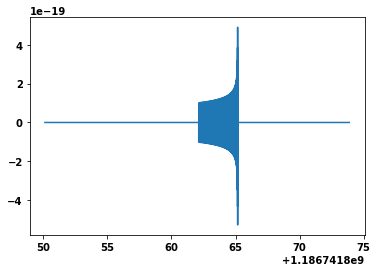

In [6]:
plt.plot(hp.sample_times, hp)

In [7]:
data = strain+hp

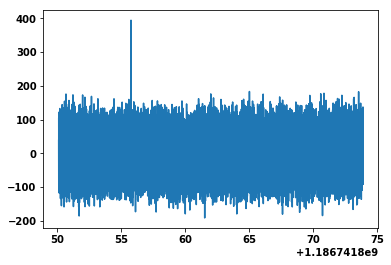

In [8]:
plt.plot(data.sample_times, data)

Text(0,0.5,'Normalized amplitude')

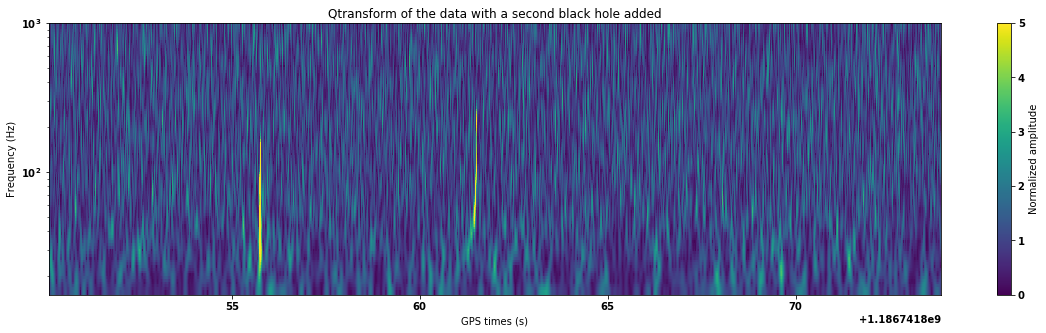

In [9]:
#qtransform of the addition
t, f, p = data.qtransform(0.001, logfsteps = 100, qrange = (8,8),
                         frange=(15,1000))
plt.figure(figsize = [20,5])
plt.title("Qtransform of the data with a second black hole added")
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.yscale('log')
plt.xlabel("GPS times (s)")
plt.ylabel("Frequency (Hz)")
plt.ylim(0,1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We try to have a best fit templte of the event that is initially present in order to subtract it and have a noise time signal.

**Build best fit template**

In [10]:
from pycbc import filter
from pycbc.types import Array

from pycbc.waveform import get_td_waveform

In [11]:
merger = Merger("GW170814")

f_lower = 20.
f_upper = 1024.

# Get the data from the Livingston detector
strain = merger.strain('L1')
psd = strain.psd(2)
psd = interpolate(psd, strain.delta_f)
psd = inverse_spectrum_truncation(psd, 2 * strain.sample_rate)

white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()
white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
white_data = white_data.time_slice(merger.time-.2, merger.time+.1)

In [12]:
def gen_template(theta,
                 delta_t=strain.delta_t,
                 duration=strain.duration,
                 start_time=strain.start_time,
                 f_lower=f_lower):
    
    m1, m2, distance, inclination, time, phase = theta

    hp, hc = get_td_waveform(approximant="SEOBNRv4_opt",
                             mass1=m1,
                             mass2=m2,
                             spin1z=-0.568797,
                             spin2z=0.13079314,
                             distance=distance,
                             inclination=inclination,
                             coa_phase=phase,
                             delta_t=delta_t,
                             f_lower=f_lower)

    # Resize the signal buffer, and shift to the requested time
    hp.resize(int(duration/delta_t))
    hp = hp.cyclic_time_shift(hp.start_time + time - strain.start_time)
    hp.start_time = strain.start_time

    return hp

In [13]:
df = strain.to_frequencyseries()

def loglikelihood(theta, df=df, f_lower=f_lower, f_upper=f_upper):
    N = int(df.duration/df.delta_t)
    
    template = gen_template(theta, delta_t=df.delta_t, f_lower=f_lower)
    hf = template.to_frequencyseries()
    
    kmin, kmax = filter.get_cutoff_indices(f_lower, f_upper, df.delta_f, (N - 1) * 2)

    hh = sum(4.0 * df.delta_f * (hf[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    dh = sum(4.0 * df.delta_f * (df[kmin:kmax].conj()*hf[kmin:kmax]).real()/psd[kmin:kmax])
    logl = -0.5*(hh - 2.0*dh)

    return logl

In [14]:
def whiten_trim_template(template, psd=psd):
    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)
    return white_template

def plot_whitened_strains(strain, template):
    white_data = (strain.to_frequencyseries() / psd**0.5).to_timeseries()

    tapered = template.highpass_fir(30, 512, remove_corrupted=False)
    white_template = (tapered.to_frequencyseries() / psd**0.5).to_timeseries()

    white_data = white_data.highpass_fir(30., 512).lowpass_fir(300, 512)
    white_template = white_template.highpass_fir(30, 512).lowpass_fir(300, 512)

    white_data = white_data.time_slice(merger.time-.2, merger.time+.1)
    white_template = white_template.time_slice(merger.time-.2, merger.time+.1)

    plt.figure(figsize=[15, 3])
    plt.plot(white_data.sample_times, white_data, label="Data")
    plt.plot(white_template.sample_times, white_template, label="Template")
    plt.xlim(merger.time-.2, merger.time+.1)
    plt.legend()

-61.456568205365585


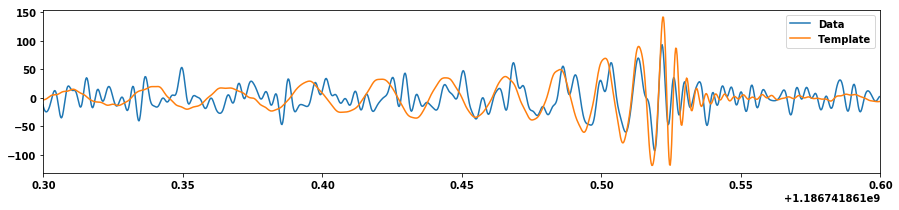

In [15]:
# m1, m2, spin1z, spin2z, distance, inclination, time, phase (trial with fixed spins)
theta0 = [31., 25., 580.,0.6, float(merger.time)+0.025,0]

template0 = gen_template(theta0)
plot_whitened_strains(strain, template0)

print(loglikelihood(theta0))

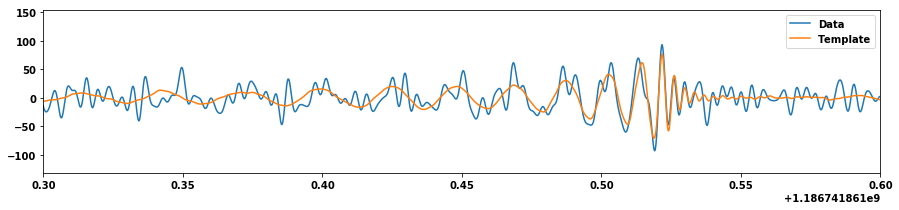

Steps	log(likelihood)
9	85.755


In [16]:
from scipy.optimize import minimize
from IPython.display import display, clear_output

fig, ax = plt.subplots(1, 1, figsize=[15, 3])
Neval = 1

whitened_template = whiten_trim_template(gen_template(theta0))

plt.plot(white_data.sample_times, white_data, label="Data")
line, = plt.plot(whitened_template.sample_times, whitened_template, label="Template")

plt.xlim(merger.time-.2, merger.time+.1)
plt.legend()

def callback(thetai):
    global Neval
    global line
    global fig
    
    template = gen_template(thetai)
    white_template = whiten_trim_template(gen_template(thetai))
    line.set_ydata(white_template)

    clear_output(wait=True)
    display(fig)
    print("Steps\tlog(likelihood)")
    print('{}\t{:.3f}'.format(Neval, loglikelihood(thetai)))
    
    Neval += 1
    
res = minimize(lambda theta: -loglikelihood(theta), theta0, callback=callback, method='powell')
plt.close()

[ 3.11241027e+01  2.50041171e+01  1.23573083e+03  4.20243494e-08
  1.18674186e+09 -3.77985234e-01]


Text(0.5,1,'Whitened strain and template for the L1 detector')

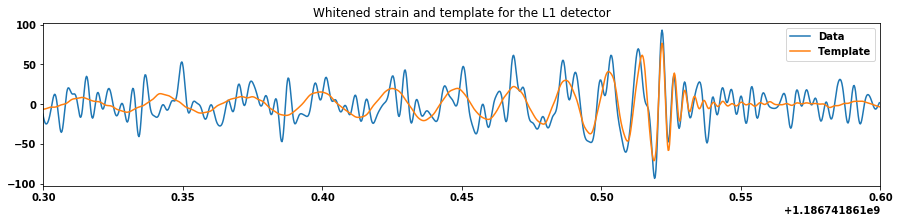

In [17]:
best_fit = res.x
best_fit_template = gen_template(best_fit)
print(best_fit)
plot_whitened_strains(strain, best_fit_template)
plt.title("Whitened strain and template for the L1 detector")

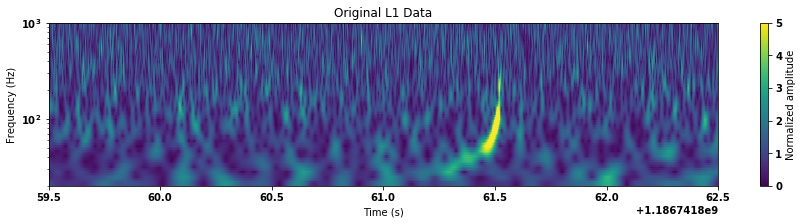

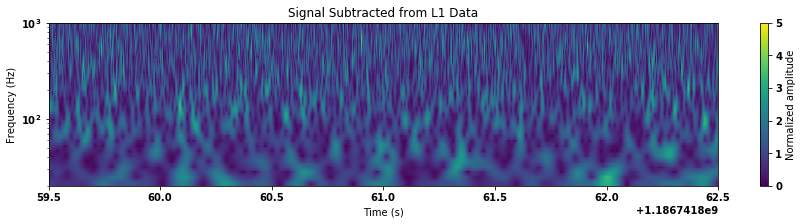

In [18]:
subtracted = strain - best_fit_template

# Plot the original data and the subtracted signal data

for data, title in [(strain, 'Original L1 Data'),
                    (subtracted, 'Signal Subtracted from L1 Data')]:

    t, f, p = data.whiten(4, 4).qtransform(.001,
                                          logfsteps=100,
                                          qrange=(8, 8),
                                          frange=(20, 1000))
    plt.figure(figsize=[15, 3])
    plt.title(title)
    im=plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
    plt.yscale('log')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.xlim(merger.time - 2, merger.time + 1)
    plt.ylim(0,1000)
    cbar=plt.colorbar()
    cbar.ax.set_ylabel("Normalized amplitude")

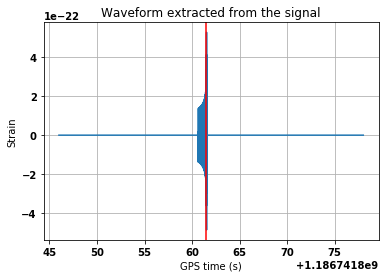

In [19]:
plt.plot(best_fit_template.sample_times, best_fit_template)
plt.title("Waveform extracted from the signal")
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.axvline(merger.time, color = 'red')
plt.grid()

The subtracted template is alligned on the merger time. So, we try to put the other event with a slight shift with respect to that

In [20]:
#make signal 
hpSE, hcSE = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 18.,
                        mass2 = 30., delta_t = strain.delta_t, distance = 580,
                         f_lower = 15.)
hpSE.resize(len(strain))
hpSE = hpSE.cyclic_time_shift(+12)
hpSE.start_time = strain.start_time

In [21]:
test = best_fit_template + hpSE

Text(0,0.5,'Strain')

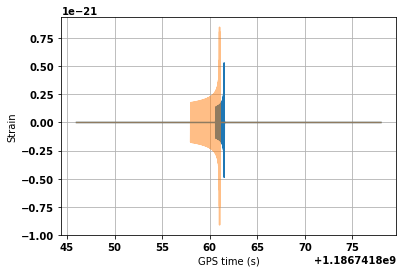

In [22]:
plt.plot(best_fit_template.sample_times, best_fit_template,
         label = 'GW170814 signal')
plt.plot(hpSE.sample_times, hpSE, alpha = 0.5, label = 'added signal')
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")

We can try to reinject that in the noise that has been left and look at the matched filtering. This is a first test. We would need to find a way to see where the merger would happen (maybe with a matched filtering done on the separeted signal reinjected?)

In [23]:
sig_test = subtracted + test

Text(0,0.5,'Normalized amplitude')

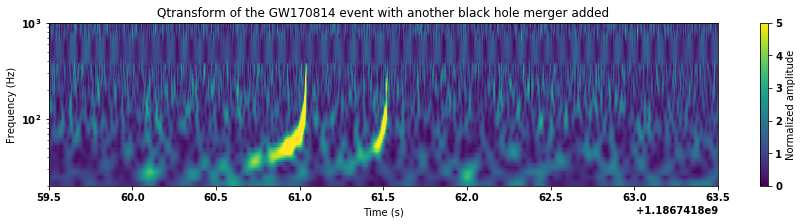

In [24]:
#qtransform of the noise and signal
t, f, p = sig_test.qtransform(.001, logfsteps=100, qrange=(8, 8),
                                          frange=(20, 1000))
plt.figure(figsize=[15, 3])
plt.title("Qtransform of the GW170814 event with another black hole merger added")
im=plt.pcolormesh(t, f, p**0.5, vmin=0, vmax=5)
plt.yscale('log')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.xlim(merger.time - 2, merger.time + 2)
plt.ylim(0,1000)
cbar=plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

Text(0.5,1,'Estimate of the psd of the data')

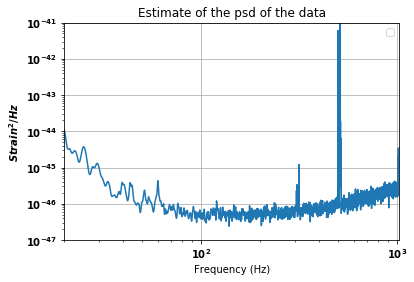

In [25]:
#trial of matched filtering

#first build PSD of the data
p = sig_test.psd(2)
p = interpolate(p, sig_test.delta_f)
psd = inverse_spectrum_truncation(p, 2*sig_test.sample_rate, 
                                  low_frequency_cutoff = 15.0)


plt.loglog(psd.sample_frequencies, psd)
plt.ylim(1e-47, 1e-41)
plt.xlim(20, 1024)
plt.ylabel('$Strain^2 / Hz$')
plt.xlabel('Frequency (Hz)')
plt.grid()
plt.legend()
plt.title("Estimate of the psd of the data")

In [26]:
#build the frequency series template
from pycbc.waveform import get_fd_waveform

hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=sig_test.delta_f, f_final=739.0645)
hp.resize(len(psd))
template=hp.cyclic_time_shift(hp.start_time)

We found a signal at 1186741861.5244141s with a SNR of 12.8973674 


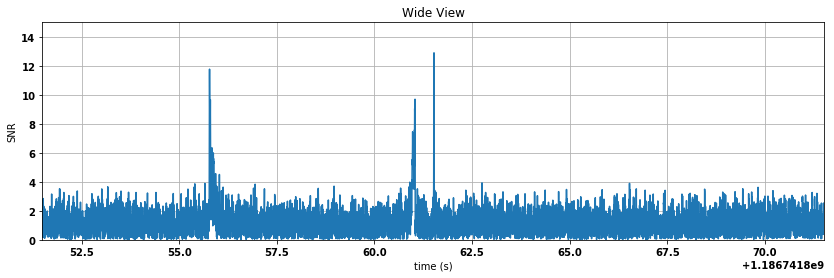

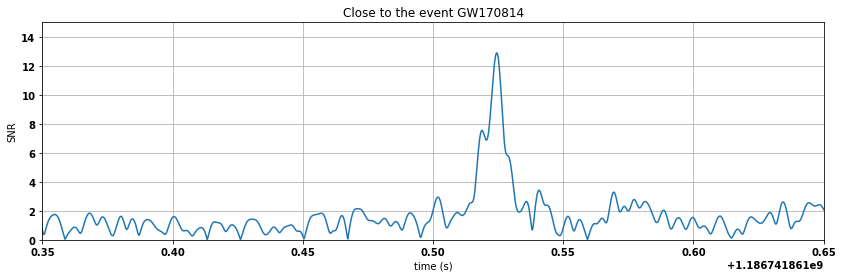

In [27]:
from pycbc.filter import matched_filter
import numpy

snr = matched_filter(template, sig_test, psd = psd, 
                     low_frequency_cutoff = 20.0)
snr = snr.crop(5,4)


for w, title in [(10, 'Wide View'), (.15, 'Close to the event GW170814')]:
    plt.figure(figsize=(14,4))
    plt.plot(snr.sample_times, abs(snr))
    if w == 10:
        peak = abs(snr).numpy().argmax()
        snrp = snr[peak]
        time = snr.sample_times[peak]
        print("We found a signal at %.7fs with a SNR of %.7f " %(time, abs(snrp)))
    plt.title(title)
    plt.grid()
    plt.xlim(m.time-w, m.time+w)
    plt.ylim(0,15)
    plt.xlabel("time (s)")
    plt.ylabel("SNR")
    


### The test now would be to find a way to see the difference in time between the two mergers.

The first idea that I have is to use the cyclic time shift to place the second signal anywhere around the other event but find the relation between the two mergers using an argmax() for the numpy array. So, at the end, we could see if how the SNR changes as function of this event.

In [28]:
#find the merger time for the hp (added signal)
import numpy

idx = hpSE.numpy().argmax()
amp_max = hpSE[idx]
time_max = hpSE.sample_times[idx]

In [29]:
print(time_max)
print(merger.time)

1186741861.0371094
1186741861.5


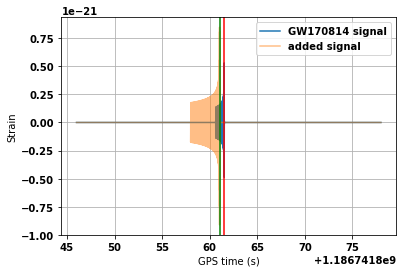

In [30]:
plt.plot(best_fit_template.sample_times, best_fit_template,
         label = 'GW170814 signal')
plt.plot(hpSE.sample_times, hpSE, alpha = 0.5, label = 'added signal')
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")
plt.legend(loc='best')
plt.axvline(time_max, color = 'green')
plt.axvline(merger.time, color= 'red')

In [31]:
# time shift calculation
print(time_max - merger.time)

-0.462890625


In [32]:
# find maximum of the data for the merger and compare with merger time
idx = best_fit_template.numpy().argmax()
amp_max = best_fit_template[idx]
time_max = best_fit_template.sample_times[idx]

print(merger.time, time_max)

(1186741861.5, 1186741861.5217285)


We see that the times correspond relatively well. So, we can think about use this as has been explained at the start.

The idea is to look at how the SNR for the event that is sought react as a function of the time between the two mergers

In [ ]:
import numpy as np

time_shifts = np.arange(0, 32, 0.01)
snrs = [None for i in range(len(time_shifts))]
time_diffs = [0 for i in range(len(time_shifts))]
times = [0 for i in range(len(time_shifts))]
time_snrs = [0 for i in range(len(time_shifts))]
max_snrs = [0 for i in range(len(time_shifts))]

c = 1

for t in range(len(time_shifts)):
    print("loop %i/%i" %(c, len(time_shifts)))
    c +=1
    #making signal to add with a shift and find the time of the max
    
    
    hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 18.,
                        mass2 = 30., delta_t = strain.delta_t, 
                        distance = 580,f_lower = 15.)
    
    hp.resize(len(strain))
    hp = hp.cyclic_time_shift(+time_shifts[t])
    hp.start_time = strain.start_time
    
    idx = hp.numpy().argmax()
    times[t] = hp.sample_times[idx]
    time_diffs[t] = times[t] - merger.time
    
    #making the full signal
    signal = strain + hp
    
    #build the PSD of the signal
    
    p = signal.psd(2)
    p = interpolate(p, signal.delta_f)
    psd = inverse_spectrum_truncation(p, 2*signal.sample_rate, 
                                     low_frequency_cutoff = 15.)
    
    # build the template that should be matched
    #Could probably be done out of the loop but it is resized on the PSD
    #and so we are sure that there won't be any error from that standpoint
    
    temp_hp, temp_hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, 
                         spin2z=0.13079314, distance=540, 
                         inclination=0.6, f_lower=20.0, 
                        delta_f=sig_test.delta_f, f_final=739.0645)
    
    temp_hp.resize(len(psd))
    template = temp_hp.cyclic_time_shift(temp_hp.start_time)
    
    # compute the snrs
    
    snr = matched_filter(template, signal, psd = psd, 
                         low_frequency_cutoff = 20.)
    snrs[t] = snr.crop(5,4)
    indx = abs(snrs[t]).numpy().argmax()
    max_snrs[t] = abs(snrs[t])[indx]
    time_snrs[t] = snrs[t].sample_times[indx]
    
    
    
    

Text(0.5,1,'SNR as function of the time gap between the two mergers')

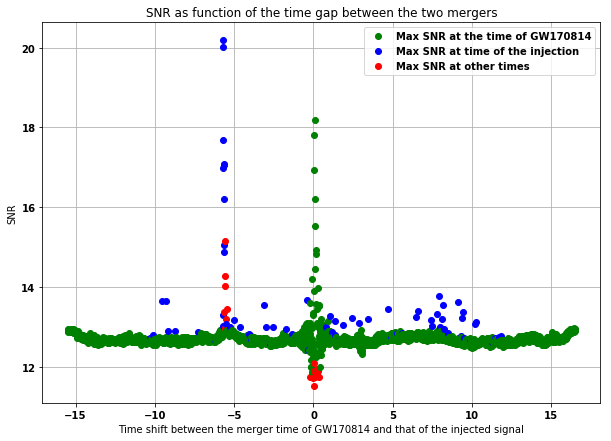

In [34]:
l = 1
k = 1
j = 1


plt.figure(figsize = [10,7])
for i in range(len(time_shifts)):
    if (abs(time_snrs[i] - merger.time) < 0.1 ):
        if l == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og', label = 'Max SNR at the time of GW170814')
            l = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og')
    elif (abs(times[i] - time_snrs[i] ) < 0.1):
        if j == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob', label = 'Max SNR at time of the injection')
            j = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob')
    
    else:
        if k == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or', label = 'Max SNR at other times')
            k = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or')
plt.legend(loc='best')
#plt.ylim(10,13.5)
plt.grid()
plt.ylabel("SNR")
plt.xlabel("Time shift between the merger time of GW170814 and that of the injected signal",)
plt.title("SNR as function of the time gap between the two mergers")
              

In [35]:
results = open("Black_holes_overlap.txt", "w")

for i in range(len(time_shifts)):
    results.write("Merger time: %.3f; time diff: %.3f; SNR: %.3f; time SNR: %.3f " %(times[i], time_diffs[i], abs(max_snrs[i]), time_snrs[i]) )
    results.write("\n")
    

Text(0.5,1,'SNR as function of the time gap between the two mergers')

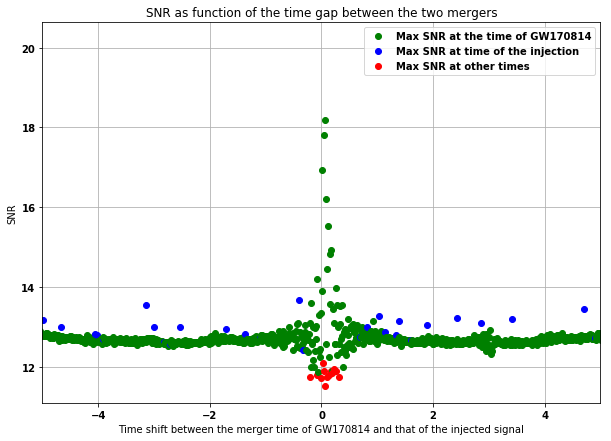

In [36]:
# zoom on the region close to the merger


l = 1
k = 1
j = 1

plt.figure(figsize = [10,7])
for i in range(len(time_shifts)):
    if (abs(time_snrs[i] - merger.time) < 0.1 ):
        if l == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og', label = 'Max SNR at the time of GW170814')
            l = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og')
    elif (abs(times[i] - time_snrs[i] ) < 0.1):
        if j == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob', label = 'Max SNR at time of the injection')
            j = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob')
    
    else:
        if k == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or', label = 'Max SNR at other times')
            k = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or')
plt.legend(loc='best')
plt.xlim(-5 , 5)
plt.grid()
plt.ylabel("SNR")
plt.xlabel("Time shift between the merger time of GW170814 and that of the injected signal",)
plt.title("SNR as function of the time gap between the two mergers")
              

Text(0.5,1,'SNR as function of the time gap between the two mergers')

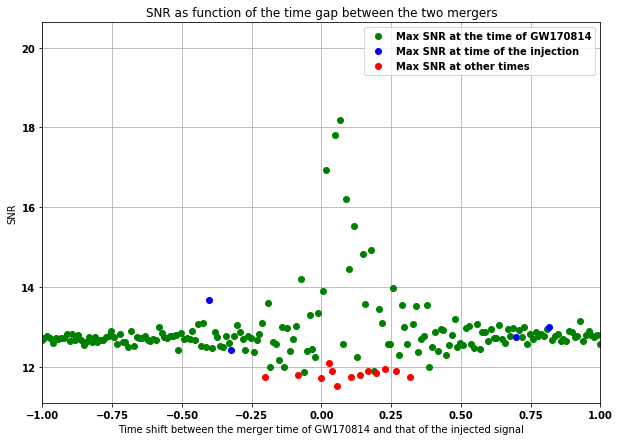

In [37]:
# zoom even closer on the region close to the merger


l = 1
k = 1
j = 1

plt.figure(figsize = [10,7])
for i in range(len(time_shifts)):
    if (abs(time_snrs[i] - merger.time) < 0.1 ):
        if l == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og', label = 'Max SNR at the time of GW170814')
            l = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og')
    elif (abs(times[i] - time_snrs[i] ) < 0.1):
        if j == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob', label = 'Max SNR at time of the injection')
            j = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob')
    
    else:
        if k == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or', label = 'Max SNR at other times')
            k = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or')
plt.legend(loc='best')
plt.xlim(-1 , 1)
plt.grid()
plt.ylabel("SNR")
plt.xlabel("Time shift between the merger time of GW170814 and that of the injected signal",)
plt.title("SNR as function of the time gap between the two mergers")
              

At the end, the behaviour of the SNR seems to be more complicated than expected. The technique is not completely lost but there are some errors that appear when the two mergers become too close. However, this is done with the optimal template. It could be that, in the case of a less well defined template, the matching is even more hasardeous. 

We can than look at the influennce of the masses. Therefore, we take 3 different models to inject. We keep the m1 equal to that of the signal, take the second on time lower (like 8M_sun), one time equal and one time higher (also 8M_sun), to see the influence of this variation. We can plot that in one graph but look at less sample points in order to make it more readable

In [38]:
import numpy as np

time_shifts = np.arange(0, 32, 0.1)
situations = ['low', 'eq', 'high']
mass =  {}
mass['low'] = 17.
mass['eq'] = 25.
mass['high'] = 33.
time_diffs = {}
times = {}
time_snrs = {}
max_snrs = {}
snrs = {}
for sit in situations:
    
    time_diffs[sit] = [0 for i in range(len(time_shifts))]
    times[sit] = [0 for i in range(len(time_shifts))]
    time_snrs[sit] = [0 for i in range(len(time_shifts))]
    max_snrs[sit] = [0 for i in range(len(time_shifts))]
    snrs[sit] = [None for i in range(len(time_shifts))]

c = 1

for s in situations:
    print("Situation: %s" %s)
    
    for t in range(len(time_shifts)):
        print("loop %i/%i" %(c, len(time_shifts)))
        c +=1
        #making signal to add with a shift and find the time of the max
    
    
        hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 31.,
                        mass2 = mass[s], delta_t = strain.delta_t, 
                        distance = 580,f_lower = 15.)
    
        hp.resize(len(strain))
        hp = hp.cyclic_time_shift(+time_shifts[t])
        hp.start_time = strain.start_time
    
        idx = hp.numpy().argmax()
        times[s][t] = hp.sample_times[idx]
        time_diffs[s][t] = times[s][t] - merger.time
    
        #making the full signal
        signal = strain + hp
    
        #build the PSD of the signal
    
        p = signal.psd(2)
        p = interpolate(p, signal.delta_f)
        psd = inverse_spectrum_truncation(p, 2*signal.sample_rate, 
                                     low_frequency_cutoff = 15.)
    
        # build the template that should be matched
        #Could probably be done out of the loop but it is resized on the PSD
        #and so we are sure that there won't be any error from that standpoint
    
        temp_hp, temp_hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, 
                         spin2z=0.13079314, distance=540, 
                         inclination=0.6, f_lower=20.0, 
                        delta_f=sig_test.delta_f, f_final=739.0645)
    
        temp_hp.resize(len(psd))
        template = temp_hp.cyclic_time_shift(temp_hp.start_time)
    
        # compute the snrs
    
        snr = matched_filter(template, signal, psd = psd, 
                         low_frequency_cutoff = 20.)
        snrs[s][t] = snr.crop(5,4)
        indx = abs(snrs[s][t]).numpy().argmax()
        max_snrs[s][t] = abs(snrs[s][t])[indx]
        time_snrs[s][t] = snrs[s][t].sample_times[indx]
    
    print("DONE")
    

Situation: low
loop 1/320
loop 2/320
loop 3/320
loop 4/320
loop 5/320
loop 6/320
loop 7/320
loop 8/320
loop 9/320
loop 10/320
loop 11/320
loop 12/320
loop 13/320
loop 14/320
loop 15/320
loop 16/320
loop 17/320
loop 18/320
loop 19/320
loop 20/320
loop 21/320
loop 22/320
loop 23/320
loop 24/320
loop 25/320
loop 26/320
loop 27/320
loop 28/320
loop 29/320
loop 30/320
loop 31/320
loop 32/320
loop 33/320
loop 34/320
loop 35/320
loop 36/320
loop 37/320
loop 38/320
loop 39/320
loop 40/320
loop 41/320
loop 42/320
loop 43/320
loop 44/320
loop 45/320
loop 46/320
loop 47/320
loop 48/320
loop 49/320
loop 50/320
loop 51/320
loop 52/320
loop 53/320
loop 54/320
loop 55/320
loop 56/320
loop 57/320
loop 58/320
loop 59/320
loop 60/320
loop 61/320
loop 62/320
loop 63/320
loop 64/320
loop 65/320
loop 66/320
loop 67/320
loop 68/320
loop 69/320
loop 70/320
loop 71/320
loop 72/320
loop 73/320
loop 74/320
loop 75/320
loop 76/320
loop 77/320
loop 78/320
loop 79/320
loop 80/320
loop 81/320
loop 82/320
loop 83/32

loop 638/320
loop 639/320
loop 640/320
DONE
Situation: high
loop 641/320
loop 642/320
loop 643/320
loop 644/320
loop 645/320
loop 646/320
loop 647/320
loop 648/320
loop 649/320
loop 650/320
loop 651/320
loop 652/320
loop 653/320
loop 654/320
loop 655/320
loop 656/320
loop 657/320
loop 658/320
loop 659/320
loop 660/320
loop 661/320
loop 662/320
loop 663/320
loop 664/320
loop 665/320
loop 666/320
loop 667/320
loop 668/320
loop 669/320
loop 670/320
loop 671/320
loop 672/320
loop 673/320
loop 674/320
loop 675/320
loop 676/320
loop 677/320
loop 678/320
loop 679/320
loop 680/320
loop 681/320
loop 682/320
loop 683/320
loop 684/320
loop 685/320
loop 686/320
loop 687/320
loop 688/320
loop 689/320
loop 690/320
loop 691/320
loop 692/320
loop 693/320
loop 694/320
loop 695/320
loop 696/320
loop 697/320
loop 698/320
loop 699/320
loop 700/320
loop 701/320
loop 702/320
loop 703/320
loop 704/320
loop 705/320
loop 706/320
loop 707/320
loop 708/320
loop 709/320
loop 710/320
loop 711/320
loop 712/320
loop

Text(0.5,1,'SNR as function of the time gap between the two mergers, for different models')

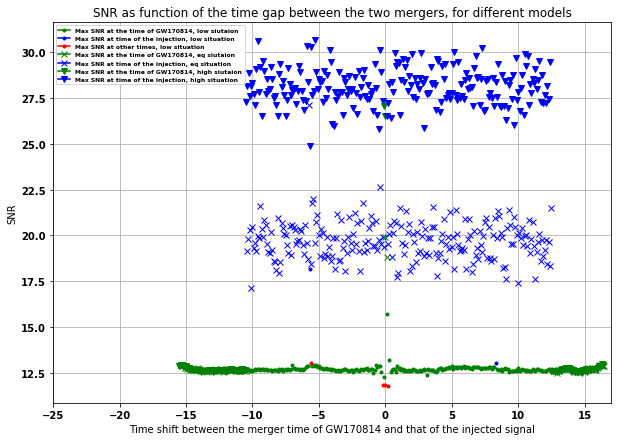

In [43]:
plt.figure(figsize = [10,7])

col = ['green', 'blue', 'red']
markers = [".", "x", "v"]

cl = 0

for sit in situations:
    l = 1
    k = 1
    j = 1
    
    
    for i in range(len(time_shifts)):
        if (abs(time_snrs[sit][i] - merger.time) < 0.1 ):
            if l == 1:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker= markers[cl],  color = 'green' , label = 'Max SNR at the time of GW170814, %s siutaion' %sit)
                l = 12
            else:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker = markers[cl], color = 'green' )
        elif (abs(times[sit][i] - time_snrs[sit][i] ) < 0.1):
    
            if j == 1:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker = markers[cl], color = 'blue', label = 'Max SNR at time of the injection, %s situation' %sit)
                j = 12
            else:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker = markers[cl], color = 'blue')
    
        else:
            if k == 1:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker = markers[cl], color = 'red', label = 'Max SNR at other times, %s situation' %sit)
                k = 12
            else:
                plt.plot(time_diffs[sit][i], abs(max_snrs[sit][i]), marker = markers[cl], color = 'red')
        
    cl = cl +1
plt.legend(loc='upper left', prop = {'size' : 6})
plt.xlim(-25, 17)
plt.grid()
plt.ylabel("SNR")
plt.xlabel("Time shift between the merger time of GW170814 and that of the injected signal",)
plt.title("SNR as function of the time gap between the two mergers, for different models")
              

We see that wben the masses are equal or more important, the matched filtering does not work any more. This means that we could only retrive the event with a higher mass compenent present. Note that, in this case, we look at events situated at the same distance, which gives a higher amplitude to the event with higher masses

Text(0.5,1,'SNR for  the GW170814 event and another injected miwth a time difference of 2.21 s between the mergers')

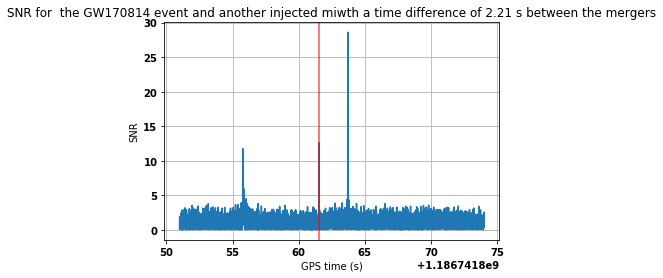

In [63]:
# snr when the events are relatively far appart
plt.plot(snrs['high'][160].sample_times, abs(snrs['high'][160]))
plt.axvline(merger.time + 0.01, color = 'red', alpha = 0.7)
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.title("SNR for  the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][160]))

Text(0.5,1,'SNR for  the GW170814 event and another injected miwth a time difference of 0.01 s between the mergers')

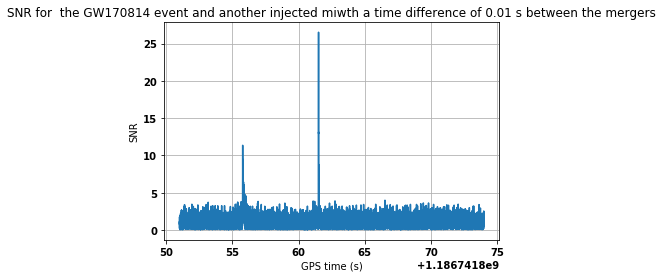

In [64]:
# we can look at what happens for the SNR when the events 
#are really close to each other
plt.plot(snrs['high'][138].sample_times, abs(snrs['high'][138]))
#plt.axvline(merger.time + 0.01, color = 'red', alpha = 0.7)
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.title("SNR for  the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][138]))

1186741861.5112305


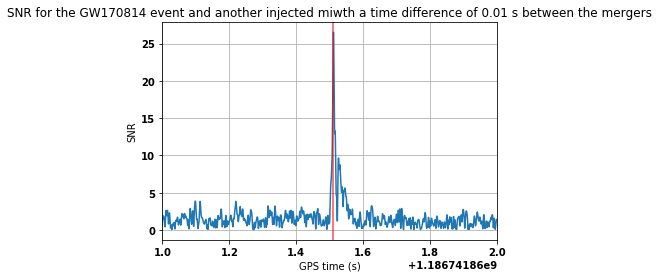

In [65]:
#zoomed view on the overlap
plt.plot(snrs['high'][138].sample_times, abs(snrs['high'][138]))
plt.axvline(merger.time + 0.01, color = 'red', alpha = 0.7)
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.xlim(merger.time - 0.5, merger.time + 0.5)
plt.title("SNR for the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][138]))
print(time_snrs['high'][138])

Text(0.5,1,'SNR for  the GW170814 event and another injected miwth a time difference of 0.21 s between the mergers')

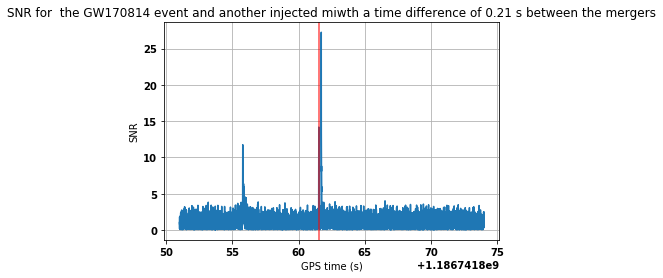

In [68]:
# snr when the events are relatively far appart
plt.plot(snrs['high'][140].sample_times, abs(snrs['high'][140]))
plt.axvline(merger.time + 0.01, color = 'red', alpha = 0.7)
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.title("SNR for  the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][140]))


(1186741860.5, 1186741862.5)

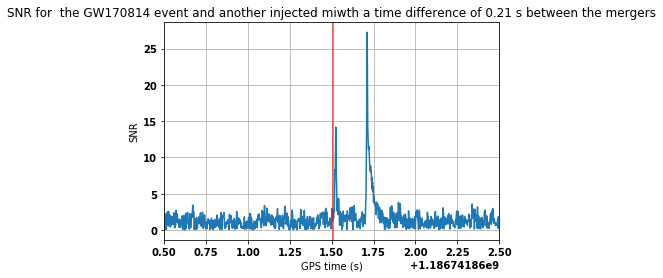

In [69]:
#zoomed view
plt.plot(snrs['high'][140].sample_times, abs(snrs['high'][140]))
plt.axvline(merger.time + 0.01, color = 'red', alpha = 0.7)
plt.grid()
plt.xlabel("GPS time (s)")
plt.ylabel("SNR")
plt.title("SNR for the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][140]))
plt.xlim(merger.time - 1, merger.time + 1)

It looks like there is a shift of the peak due to the event. In this case, we could aks ourselves if it would be possible to redetected the signal event if we first subatrected the bigger one.

We can look at a few other time shifts very close in order to se if there is indeed a motion of the peak that could be seen

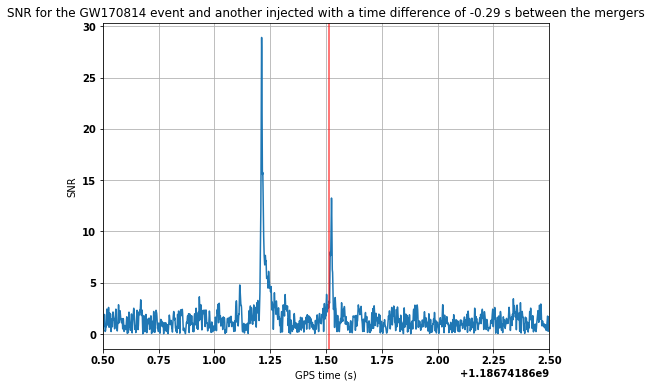

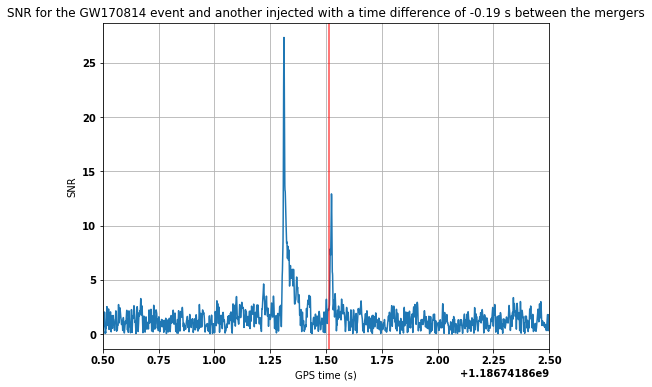

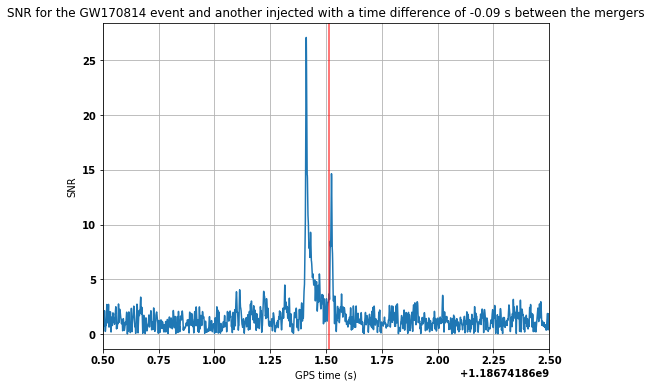

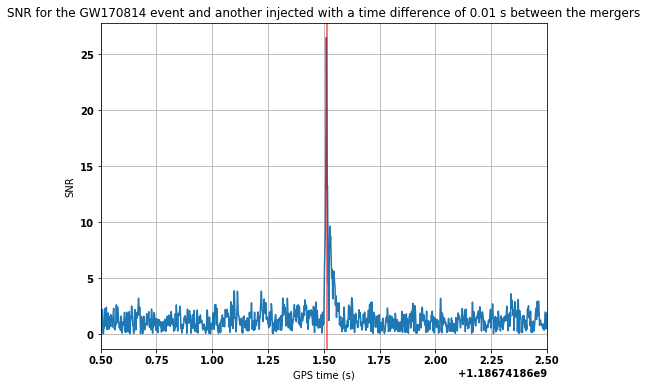

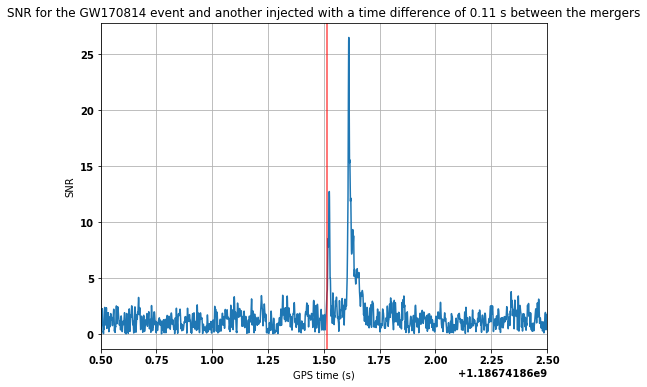

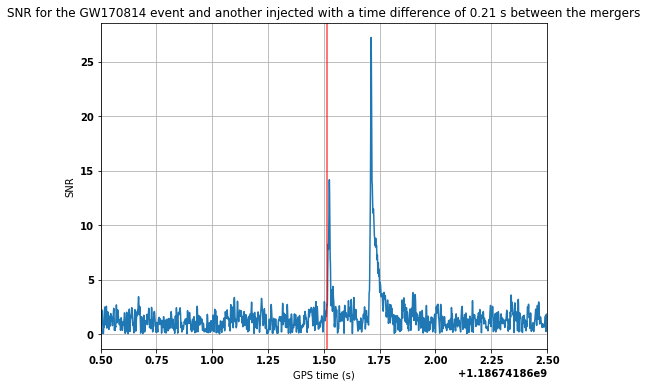

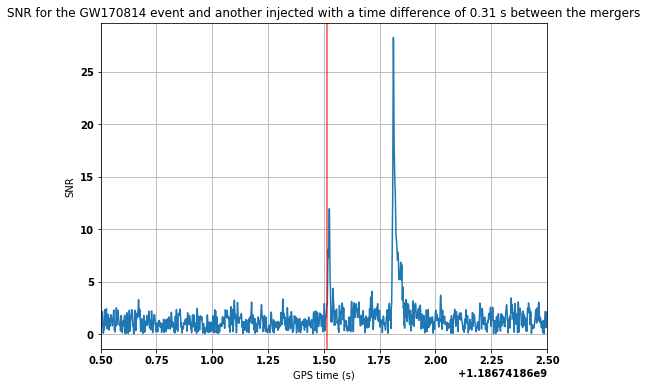

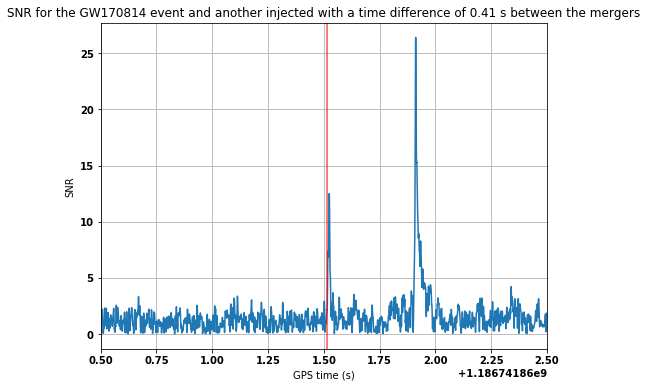

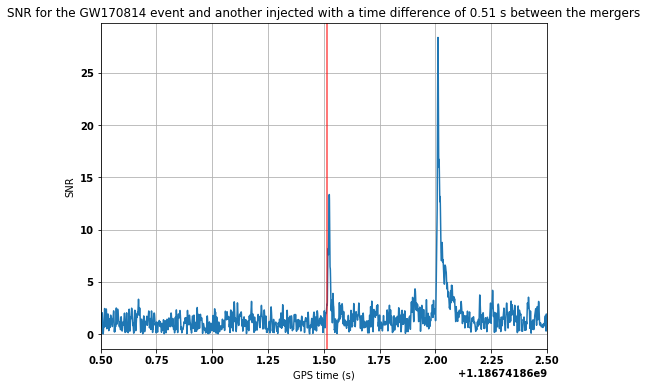

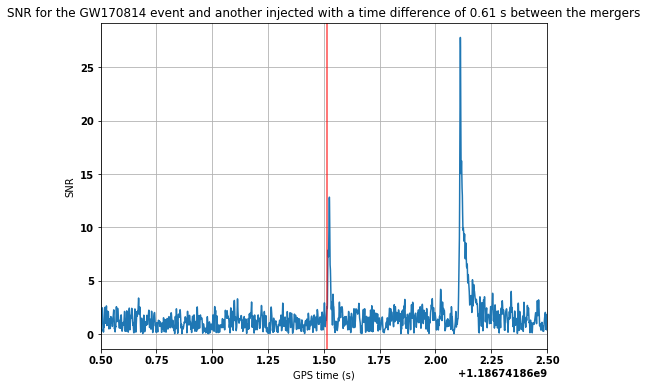

In [76]:
for i in range(135, 145, 1):
    plt.figure(figsize = [8,6])
    plt.plot(snrs['high'][i].sample_times, abs(snrs['high'][i]))
    plt.axvline(merger.time + 0.014, color = 'red', alpha = 0.7)
    plt.grid()
    plt.xlabel("GPS time (s)")
    plt.ylabel("SNR")
    plt.title("SNR for the GW170814 event and another injected with a time difference of %.2f s between the mergers" %(time_diffs['high'][i]))
    plt.xlim(merger.time - 1, merger.time + 1)

At the end, there does not seem to be any shift that is present in the peak. However, we see that that, when the peaks are at there closest (same place) the highest peak does not seem to increase in value.

We see that the value for the SNR is present at the time of the event. It even keeps the same value. However the value os higher for the event with higher masses. This is what makes the problem. However, the thing is that the template that is used is adapted to the GW170814 event and not the other. So, it seems difficult to see what is going wrong here. Maybe, it comes frome the fact that the events are relatively close to each other (the two masses are close to the highest mass). It could be interesting to see how this evloves depending on the masses. 

 we look at the evolution of the SNR for the time slice for black holes but with two masses higher than the ones that are present in the GW170814 event. This should enable to see if the fact that the SNR is always higher for the more massive case is due to the proximiy of the events or if there is bias of the matched filtering towards heavier systemes

(1186741860.0, 1186741861.7)

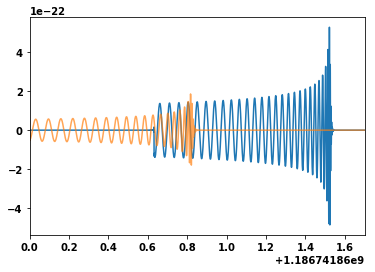

In [153]:
#compare very massive event with GW170814

hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 45.,
                        mass2 = 50., delta_t = strain.delta_t, 
                        distance = 6000,f_lower = 15.)
    
hp.resize(len(strain))
hp = hp.cyclic_time_shift(+14)
hp.start_time = strain.start_time

plt.plot(best_fit_template.sample_times, best_fit_template, label='GW170814')
plt.plot(hp.sample_times, hp, alpha = 0.7, label='injected signal')

plt.xlim(merger.time-1.5, merger.time + 0.2)

In [144]:
import numpy as np

time_shifts = np.arange(0, 32, 0.01)
snrs = [None for i in range(len(time_shifts))]
time_diffs = [0 for i in range(len(time_shifts))]
times = [0 for i in range(len(time_shifts))]
time_snrs = [0 for i in range(len(time_shifts))]
max_snrs = [0 for i in range(len(time_shifts))]

c = 1

for t in range(len(time_shifts)):
    print("loop %i/%i" %(c, len(time_shifts)))
    c +=1
    #making signal to add with a shift and find the time of the max
    
    
    hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 45.,
                        mass2 = 50., delta_t = strain.delta_t, 
                        distance = 1500,f_lower = 15.)
    
    hp.resize(len(strain))
    hp = hp.cyclic_time_shift(+time_shifts[t])
    hp.start_time = strain.start_time
    
    idx = hp.numpy().argmax()
    times[t] = hp.sample_times[idx]
    time_diffs[t] = times[t] - merger.time
    
    #making the full signal
    signal = strain + hp
    
    #build the PSD of the signal
    
    p = signal.psd(2)
    p = interpolate(p, signal.delta_f)
    psd = inverse_spectrum_truncation(p, 2*signal.sample_rate, 
                                     low_frequency_cutoff = 15.)
    
    # build the template that should be matched
    #Could probably be done out of the loop but it is resized on the PSD
    #and so we are sure that there won't be any error from that standpoint
    
    hp, hf = get_fd_waveform(approximant="IMRPhenomD",
                         mass1=30.5, mass2=25.3, spin1z=-0.56879753, spin2z=0.13079314, distance=540, inclination=0.6,
                         f_lower=20.0, delta_f=signal.delta_f, f_final=739.0645)
    
    temp_hp.resize(len(psd))
    template = temp_hp.cyclic_time_shift(temp_hp.start_time)
    
    # compute the snrs
    
    snr = matched_filter(template, signal, psd = psd, 
                         low_frequency_cutoff = 20.)
    snrs[t] = snr.crop(1,1)
    indx = abs(snrs[t]).numpy().argmax()
    max_snrs[t] = abs(snrs[t])[indx]
    time_snrs[t] = snrs[t].sample_times[indx]
    
    
    
    

loop 1/3200
loop 2/3200
loop 3/3200
loop 4/3200
loop 5/3200
loop 6/3200
loop 7/3200
loop 8/3200
loop 9/3200
loop 10/3200
loop 11/3200
loop 12/3200
loop 13/3200
loop 14/3200
loop 15/3200
loop 16/3200
loop 17/3200
loop 18/3200
loop 19/3200
loop 20/3200
loop 21/3200
loop 22/3200
loop 23/3200
loop 24/3200
loop 25/3200
loop 26/3200
loop 27/3200
loop 28/3200
loop 29/3200
loop 30/3200
loop 31/3200
loop 32/3200
loop 33/3200
loop 34/3200
loop 35/3200
loop 36/3200
loop 37/3200
loop 38/3200
loop 39/3200
loop 40/3200
loop 41/3200
loop 42/3200
loop 43/3200
loop 44/3200
loop 45/3200
loop 46/3200
loop 47/3200
loop 48/3200
loop 49/3200
loop 50/3200
loop 51/3200
loop 52/3200
loop 53/3200
loop 54/3200
loop 55/3200
loop 56/3200
loop 57/3200
loop 58/3200
loop 59/3200
loop 60/3200
loop 61/3200
loop 62/3200
loop 63/3200
loop 64/3200
loop 65/3200
loop 66/3200
loop 67/3200
loop 68/3200
loop 69/3200
loop 70/3200
loop 71/3200
loop 72/3200
loop 73/3200
loop 74/3200
loop 75/3200
loop 76/3200
loop 77/3200
loop 78/

loop 595/3200
loop 596/3200
loop 597/3200
loop 598/3200
loop 599/3200
loop 600/3200
loop 601/3200
loop 602/3200
loop 603/3200
loop 604/3200
loop 605/3200
loop 606/3200
loop 607/3200
loop 608/3200
loop 609/3200
loop 610/3200
loop 611/3200
loop 612/3200
loop 613/3200
loop 614/3200
loop 615/3200
loop 616/3200
loop 617/3200
loop 618/3200
loop 619/3200
loop 620/3200
loop 621/3200
loop 622/3200
loop 623/3200
loop 624/3200
loop 625/3200
loop 626/3200
loop 627/3200
loop 628/3200
loop 629/3200
loop 630/3200
loop 631/3200
loop 632/3200
loop 633/3200
loop 634/3200
loop 635/3200
loop 636/3200
loop 637/3200
loop 638/3200
loop 639/3200
loop 640/3200
loop 641/3200
loop 642/3200
loop 643/3200
loop 644/3200
loop 645/3200
loop 646/3200
loop 647/3200
loop 648/3200
loop 649/3200
loop 650/3200
loop 651/3200
loop 652/3200
loop 653/3200
loop 654/3200
loop 655/3200
loop 656/3200
loop 657/3200
loop 658/3200
loop 659/3200
loop 660/3200
loop 661/3200
loop 662/3200
loop 663/3200
loop 664/3200
loop 665/3200
loop 6

loop 1169/3200
loop 1170/3200
loop 1171/3200
loop 1172/3200
loop 1173/3200
loop 1174/3200
loop 1175/3200
loop 1176/3200
loop 1177/3200
loop 1178/3200
loop 1179/3200
loop 1180/3200
loop 1181/3200
loop 1182/3200
loop 1183/3200
loop 1184/3200
loop 1185/3200
loop 1186/3200
loop 1187/3200
loop 1188/3200
loop 1189/3200
loop 1190/3200
loop 1191/3200
loop 1192/3200
loop 1193/3200
loop 1194/3200
loop 1195/3200
loop 1196/3200
loop 1197/3200
loop 1198/3200
loop 1199/3200
loop 1200/3200
loop 1201/3200
loop 1202/3200
loop 1203/3200
loop 1204/3200
loop 1205/3200
loop 1206/3200
loop 1207/3200
loop 1208/3200
loop 1209/3200
loop 1210/3200
loop 1211/3200
loop 1212/3200
loop 1213/3200
loop 1214/3200
loop 1215/3200
loop 1216/3200
loop 1217/3200
loop 1218/3200
loop 1219/3200
loop 1220/3200
loop 1221/3200
loop 1222/3200
loop 1223/3200
loop 1224/3200
loop 1225/3200
loop 1226/3200
loop 1227/3200
loop 1228/3200
loop 1229/3200
loop 1230/3200
loop 1231/3200
loop 1232/3200
loop 1233/3200
loop 1234/3200
loop 1235/

loop 1717/3200
loop 1718/3200
loop 1719/3200
loop 1720/3200
loop 1721/3200
loop 1722/3200
loop 1723/3200
loop 1724/3200
loop 1725/3200
loop 1726/3200
loop 1727/3200
loop 1728/3200
loop 1729/3200
loop 1730/3200
loop 1731/3200
loop 1732/3200
loop 1733/3200
loop 1734/3200
loop 1735/3200
loop 1736/3200
loop 1737/3200
loop 1738/3200
loop 1739/3200
loop 1740/3200
loop 1741/3200
loop 1742/3200
loop 1743/3200
loop 1744/3200
loop 1745/3200
loop 1746/3200
loop 1747/3200
loop 1748/3200
loop 1749/3200
loop 1750/3200
loop 1751/3200
loop 1752/3200
loop 1753/3200
loop 1754/3200
loop 1755/3200
loop 1756/3200
loop 1757/3200
loop 1758/3200
loop 1759/3200
loop 1760/3200
loop 1761/3200
loop 1762/3200
loop 1763/3200
loop 1764/3200
loop 1765/3200
loop 1766/3200
loop 1767/3200
loop 1768/3200
loop 1769/3200
loop 1770/3200
loop 1771/3200
loop 1772/3200
loop 1773/3200
loop 1774/3200
loop 1775/3200
loop 1776/3200
loop 1777/3200
loop 1778/3200
loop 1779/3200
loop 1780/3200
loop 1781/3200
loop 1782/3200
loop 1783/

loop 2265/3200
loop 2266/3200
loop 2267/3200
loop 2268/3200
loop 2269/3200
loop 2270/3200
loop 2271/3200
loop 2272/3200
loop 2273/3200
loop 2274/3200
loop 2275/3200
loop 2276/3200
loop 2277/3200
loop 2278/3200
loop 2279/3200
loop 2280/3200
loop 2281/3200
loop 2282/3200
loop 2283/3200
loop 2284/3200
loop 2285/3200
loop 2286/3200
loop 2287/3200
loop 2288/3200
loop 2289/3200
loop 2290/3200
loop 2291/3200
loop 2292/3200
loop 2293/3200
loop 2294/3200
loop 2295/3200
loop 2296/3200
loop 2297/3200
loop 2298/3200
loop 2299/3200
loop 2300/3200
loop 2301/3200
loop 2302/3200
loop 2303/3200
loop 2304/3200
loop 2305/3200
loop 2306/3200
loop 2307/3200
loop 2308/3200
loop 2309/3200
loop 2310/3200
loop 2311/3200
loop 2312/3200
loop 2313/3200
loop 2314/3200
loop 2315/3200
loop 2316/3200
loop 2317/3200
loop 2318/3200
loop 2319/3200
loop 2320/3200
loop 2321/3200
loop 2322/3200
loop 2323/3200
loop 2324/3200
loop 2325/3200
loop 2326/3200
loop 2327/3200
loop 2328/3200
loop 2329/3200
loop 2330/3200
loop 2331/

loop 2812/3200
loop 2813/3200
loop 2814/3200
loop 2815/3200
loop 2816/3200
loop 2817/3200
loop 2818/3200
loop 2819/3200
loop 2820/3200
loop 2821/3200
loop 2822/3200
loop 2823/3200
loop 2824/3200
loop 2825/3200
loop 2826/3200
loop 2827/3200
loop 2828/3200
loop 2829/3200
loop 2830/3200
loop 2831/3200
loop 2832/3200
loop 2833/3200
loop 2834/3200
loop 2835/3200
loop 2836/3200
loop 2837/3200
loop 2838/3200
loop 2839/3200
loop 2840/3200
loop 2841/3200
loop 2842/3200
loop 2843/3200
loop 2844/3200
loop 2845/3200
loop 2846/3200
loop 2847/3200
loop 2848/3200
loop 2849/3200
loop 2850/3200
loop 2851/3200
loop 2852/3200
loop 2853/3200
loop 2854/3200
loop 2855/3200
loop 2856/3200
loop 2857/3200
loop 2858/3200
loop 2859/3200
loop 2860/3200
loop 2861/3200
loop 2862/3200
loop 2863/3200
loop 2864/3200
loop 2865/3200
loop 2866/3200
loop 2867/3200
loop 2868/3200
loop 2869/3200
loop 2870/3200
loop 2871/3200
loop 2872/3200
loop 2873/3200
loop 2874/3200
loop 2875/3200
loop 2876/3200
loop 2877/3200
loop 2878/

Text(0.5,1,'SNR as function of the time gap between the two mergers')

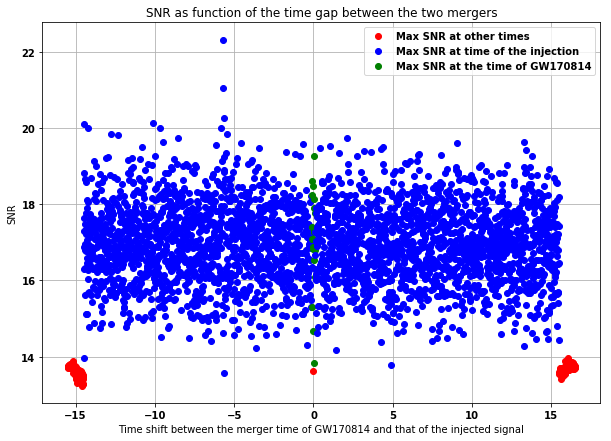

In [145]:
l = 1
k = 1
j = 1


plt.figure(figsize = [10,7])
for i in range(len(time_shifts)):
    if (abs(time_snrs[i] - merger.time) < 0.1 ):
        if l == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og', label = 'Max SNR at the time of GW170814')
            l = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'og')
    elif (abs(times[i] - time_snrs[i] ) < 0.1):
        if j == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob', label = 'Max SNR at time of the injection')
            j = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'ob')
    
    else:
        if k == 1:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or', label = 'Max SNR at other times')
            k = 12
        else:
            plt.plot(time_diffs[i], abs(max_snrs[i]), 'or')
plt.legend(loc='best')
#plt.ylim(10,13.5)
plt.grid()
plt.ylabel("SNR")
plt.xlabel("Time shift between the merger time of GW170814 and that of the injected signal",)
plt.title("SNR as function of the time gap between the two mergers")
              

It seems that, whatever happens, the highest amplitude is detected, nit especially the correct one. Hereunder, we plot the two waveforms to compate them. But, it is not logic that the good signal is found only far away. 

We compare the two waveforms in time (because it is better to see) and frequency (because it is what is used for the matched filtering) domains

Text(0,0.5,'Strain')

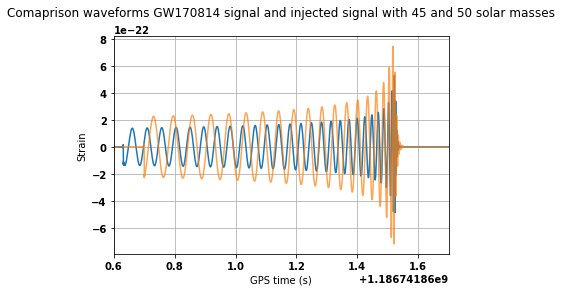

In [146]:

hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 45.,
                        mass2 = 50., delta_t = strain.delta_t, 
                        distance = 1500,f_lower = 15.)
    
hp.resize(len(strain))
hp = hp.cyclic_time_shift(+14.7)
hp.start_time = strain.start_time

plt.plot(best_fit_template.sample_times, best_fit_template, label='GW170814')
plt.plot(hp.sample_times, hp, alpha = 0.7, label='injected signal')

plt.xlim(merger.time-.9, merger.time + 0.2)
plt.grid()
plt.title("Comaprison waveforms GW170814 signal and injected signal with 45 and 50 solar masses", 
         pad = 20)
plt.xlabel("GPS time (s)")
plt.ylabel("Strain")


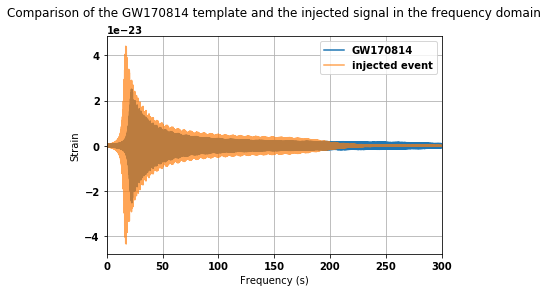

In [147]:
#in the freuqnecy domain

hp_fr = hp.to_frequencyseries()
best_fit_template_fr = best_fit_template.to_frequencyseries()

plt.plot(best_fit_template_fr.sample_frequencies, best_fit_template_fr,
        label = 'GW170814')
plt.plot(hp_fr.sample_frequencies, hp_fr, alpha = 0.7, label = 'injected event')
plt.grid()
plt.xlim(0,300)
plt.xlabel("Frequency (s)")
plt.ylabel("Strain")
plt.title("Comparison of the GW170814 template and the injected signal in the frequency domain", 
          pad = 20)
plt.legend(loc='best')

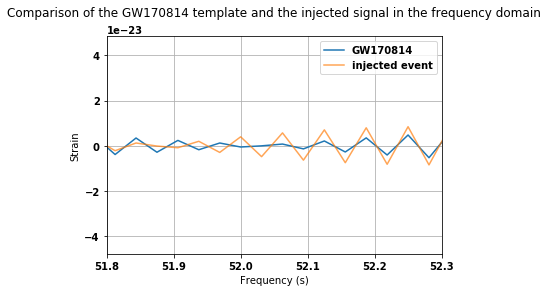

In [148]:
#closer look to see if the oscillations are well different

plt.plot(best_fit_template_fr.sample_frequencies, best_fit_template_fr,
        label = 'GW170814')
plt.plot(hp_fr.sample_frequencies, hp_fr, alpha = 0.7, label = 'injected event')
plt.grid()
plt.xlim(51.8,52.3)
plt.xlabel("Frequency (s)")
plt.ylabel("Strain")
plt.title("Comparison of the GW170814 template and the injected signal in the frequency domain", 
          pad = 20)
plt.legend(loc='best')

The shapes of the signal seem relatively similar in the case of the frequency domain. I will try to do the matched filtering in the time domain (first see if it is possible in the general case), to see if the event can better be found in that case

There is a portion where the signal is well detected, when the shift is very high (in both directions). I think that the injeted signal is slightly cut in these cases because of the cyclic time shift. This means that we have the decrease of the matched filtering peak that would be found (it would be spread in the two cases).; We will look at it hereunder to see if the behaviour is as expected

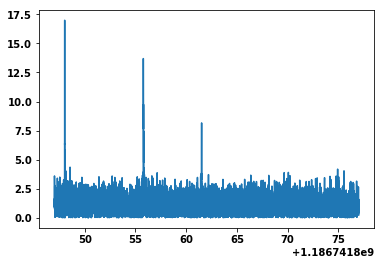

In [149]:
plt.plot(snrs[120].sample_times, abs(snrs[120]))

In [109]:
print(snrs[30].end_time-snrs[30].start_time)

23


The side lobes where the detection happens correctly is due t the croping of the SNR at the edges to avoid the artefacts. Therefore, the difference comes only from that and not from a cutting of the signal. In other terms, it means that, in the time frame considered, if there is a signal with a bigger amplitude (**hypothesis**) , the matched filtering technique will find that one, even if the parameters that are set for the template are better adjusted for the other event

In order to see what would happe in a more realisitc approach. I will look at the maximum SNR that I can find in the situation where the events are very close to each other and see which would be the parameters for the masses that are found. After that, I will subtract the signal out of the event and see if it would lead to the possibility to detect the event.

The merging time of the two events are very close to each other (nearly superposed. We can look at the possibility to extract the information

In [119]:
#first we make the signal:
hp, hf = get_td_waveform(approximant = "SEOBNRv4_opt", mass1 = 45.,
                        mass2 = 50., delta_t = strain.delta_t, 
                        distance = 580,f_lower = 15.)
    
hp.resize(len(strain))
hp = hp.cyclic_time_shift(+14.683)
hp.start_time = strain.start_time

#find the maximum and compare it to that of the merger
idx = hp.numpy().argmax()
time_merg = hp.sample_times[idx]
time_dif = time_merg - merger.time

print(time_dif)

-0.000244140625


In [120]:
#make signal
signal = strain + hp

Text(0,0.5,'Normalized amplitude')

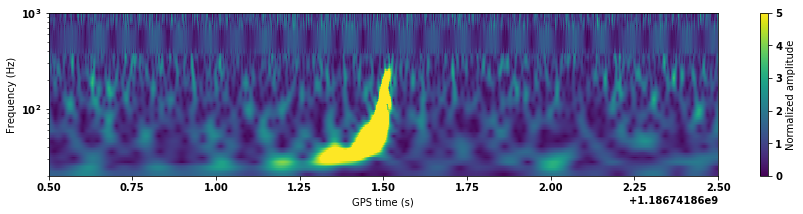

In [128]:
# qtransfrom of the data:

zoom = signal.time_slice(merger.time - 3, merger.time + 3)
t, f, p = zoom.qtransform(.001, logfsteps = 100, frange=(20,1000), 
                         qrange = (8,8))
plt.figure(figsize = [15,3])
im = plt.pcolormesh(t, f, p**0.5, vmin = 0, vmax = 5)
plt.xlim(merger.time-1, merger.time + 1)
plt.yscale('log')
plt.xlabel('GPS time (s)')
plt.ylabel("Frequency (Hz)")
plt.ylim(0,1000)
cbar = plt.colorbar()
cbar.ax.set_ylabel("Normalized amplitude")

We see that the events togheter give a big blop in the Qtransform for the banana shape.

In [133]:
#we do not mind about the spins, only the masses are looked at.
#we look which are the parameters that are found as the best possible 
#masses

Freq_signal = signal.to_frequencyseries()

psd = signal.psd(2)
psd = interpolate(psd, signal.delta_f)
psd = inverse_spectrum_truncation(psd, 2*signal.sample_rate, 
                                 low_frequency_cutoff = 20.)


mass1 = np.arange(20, 55, 0.1)
mass2 = np.arange(20, 55, 0.1)

leng = len(mass1)

max_snr, tmax, m1max, m2max, smax = 0, 0, 0, 0, 0
hmax = None
snr_max = None

times = [[] for i in range(len(mass1))]
snrs = [[] for i in range(len(mass2))]
snrps = [[] for i in range(len(mass1))]

i = 0
for m1 in mass1:
    print("Loop for m1 : %i/%i" %(i+1, leng))
    for m2 in mass2:
        #generate the waveform for the masses
        hp, hf = get_fd_waveform(approximant = "IMRPhenomD", mass1 = m1,
                                mass2 = m2, f_lower = 20,
                                delta_f = signal.delta_f)
        hp.resize(len(Freq_signal))
        
        snr = matched_filter(hp, Freq_signal, psd = psd, 
                             low_frequency_cutoff = 20)
        snr = snr.crop(2,2)
        pk = abs(snr).numpy().argmax()
        snrp = abs(snr)[pk]
        snrps[i].append(snrp)
        time = snr.sample_times[pk]
        times[i].append(time)
        
        
        #keep track of the maximum SNR
        if snrp > max_snr:
            tmax, hmax, m1max, m2max, smax, snr_max = time, hp, m1, m2, snrp, snr
    
    i += 1
    print("Done")
    
print("the best fit parameters: M1 =  %.3f M_o, M2 = %.3f M_o at time %.7f with a SNR of %.7f" %(m1max, m2max, tmax, snrp))

Loop for m1 : 1/350
Done
Loop for m1 : 2/350
Done
Loop for m1 : 3/350
Done
Loop for m1 : 4/350
Done
Loop for m1 : 5/350
Done
Loop for m1 : 6/350
Done
Loop for m1 : 7/350
Done
Loop for m1 : 8/350
Done
Loop for m1 : 9/350
Done
Loop for m1 : 10/350
Done
Loop for m1 : 11/350
Done
Loop for m1 : 12/350
Done
Loop for m1 : 13/350
Done
Loop for m1 : 14/350
Done
Loop for m1 : 15/350
Done
Loop for m1 : 16/350
Done
Loop for m1 : 17/350
Done
Loop for m1 : 18/350
Done
Loop for m1 : 19/350
Done
Loop for m1 : 20/350
Done
Loop for m1 : 21/350
Done
Loop for m1 : 22/350
Done
Loop for m1 : 23/350
Done
Loop for m1 : 24/350
Done
Loop for m1 : 25/350
Done
Loop for m1 : 26/350
Done
Loop for m1 : 27/350
Done
Loop for m1 : 28/350
Done
Loop for m1 : 29/350
Done
Loop for m1 : 30/350
Done
Loop for m1 : 31/350
Done
Loop for m1 : 32/350
Done
Loop for m1 : 33/350
Done
Loop for m1 : 34/350
Done
Loop for m1 : 35/350
Done
Loop for m1 : 36/350
Done
Loop for m1 : 37/350
Done
Loop for m1 : 38/350
Done
Loop for m1 : 39/350


Done
Loop for m1 : 309/350
Done
Loop for m1 : 310/350
Done
Loop for m1 : 311/350
Done
Loop for m1 : 312/350
Done
Loop for m1 : 313/350
Done
Loop for m1 : 314/350
Done
Loop for m1 : 315/350
Done
Loop for m1 : 316/350
Done
Loop for m1 : 317/350
Done
Loop for m1 : 318/350
Done
Loop for m1 : 319/350
Done
Loop for m1 : 320/350
Done
Loop for m1 : 321/350
Done
Loop for m1 : 322/350
Done
Loop for m1 : 323/350
Done
Loop for m1 : 324/350
Done
Loop for m1 : 325/350
Done
Loop for m1 : 326/350
Done
Loop for m1 : 327/350
Done
Loop for m1 : 328/350
Done
Loop for m1 : 329/350
Done
Loop for m1 : 330/350
Done
Loop for m1 : 331/350
Done
Loop for m1 : 332/350
Done
Loop for m1 : 333/350
Done
Loop for m1 : 334/350
Done
Loop for m1 : 335/350
Done
Loop for m1 : 336/350
Done
Loop for m1 : 337/350
Done
Loop for m1 : 338/350
Done
Loop for m1 : 339/350
Done
Loop for m1 : 340/350
Done
Loop for m1 : 341/350
Done
Loop for m1 : 342/350
Done
Loop for m1 : 343/350
Done
Loop for m1 : 344/350
Done
Loop for m1 : 345/350
D

As a conlcusion, this shows that if the mass is too high in the injected signal, then we will always detect that one first, which is not what we want. So, we need to be careful that it does not always give a high SNR. Moreover, we see that the glitch interferes with the injection when it is close-by, giving an increase of its SNR, which can go beyond the SNR of the real value. Therfore, in order to test the behaviour, it will be better to take an event that has no glitch present.